<a href="https://colab.research.google.com/github/Julialunna/Fed-DP-PSO/blob/main/Fed_DP_PSO_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install flwr
!pip install flwr-datasets
!pip install datasets

In [2]:
!pip install opacus

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.4/254.4 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 68.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 77.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Subset, TensorDataset
from torchvision import datasets, transforms
import torch.nn.functional as F
import copy
import random
import torchvision
import torchvision.models as models

import math
import numpy as np
from collections import OrderedDict

from flwr_datasets.partitioner import DirichletPartitioner, IidPartitioner
from flwr_datasets import FederatedDataset

from opacus import PrivacyEngine
from opacus.utils.batch_memory_manager import BatchMemoryManager
from opacus.accountants.utils import get_noise_multiplier
from opacus.accountants import RDPAccountant

In [4]:
class MLP(nn.Module):

    def __init__(self, device, input_size=28*28, hidden_size=256, num_classes=10):
        super(MLP, self).__init__()
        self.device = device
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, num_classes)
        self.to(device)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Achatar o tensor de entrada
        y = self.fc1(x)
        y = self.relu(y)
        y = self.fc2(y)
        y = self.relu(y)
        y = self.fc3(y)

        return y

In [19]:
# Definições dos hiperparâmetros
NUM_CLIENTES = 10
NUM_PARTICULAS = 5
NUM_RODADAS = 10
NUM_DIGITOS = 10
# INERCIA, C1, C2 = 0.8, 1.5,  1.9
INERCIA, C1, C2 = 0.7, 1.4, 1.4
# INERCIA, C1, C2 = 0.9, 1.5, 1.5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 240

print(f'training on {DEVICE}')

training on cuda


90


/usr/local/lib/python3.11/dist-packages/flwr_datasets/metrics/utils.py:130: UserWarning: The verbose names can not be established. The column specified by 'column_name' needs to be of type 'ClassLabel' to create a verbose names. The available names will used.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/opacus/privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(


tensor(-0.0227, device='cuda:0')
(4, 1.3208785758298986)
(0, 1.4221626379910637)
(7, 1.4319406467325546)
(8, 1.4695374544929056)
(5, 1.6307335390764124)
(6, 1.6400928006452673)
(1, 1.6853959770763622)
(9, 1.8671552924548878)
(3, 1.8827748929753023)
(2, 2.2573414409861847)
epsilon: 2.15018528451164
Rodada 1/10: Cliente 4 enviou os pesos!
Erro Global Atualizado: 1.3209
Epsilon 10 desbalanceado extremo 
Teste -> Perda:  1.3209, Acurácia:  69.6000%

(0, 1.0481580706203686)
(7, 1.1356631377164055)
(8, 1.1473220727022957)
(9, 1.212075380718007)
(5, 1.2312906489652746)
(4, 1.2513428645975448)
(1, 1.2795857752070707)
(3, 1.4161753724603092)
(6, 1.4171091388253605)
(2, 1.5140615631552303)
epsilon: 2.643434843937355
Rodada 2/10: Cliente 0 enviou os pesos!
Erro Global Atualizado: 1.0482
Epsilon 10 desbalanceado extremo 
Teste -> Perda:  1.0482, Acurácia:  78.6000%

(0, 0.9616968491498161)
(7, 1.026045981575461)
(8, 1.0828401972265804)
(4, 1.1233472403358011)
(9, 1.2101006437750423)
(3, 1.23126503

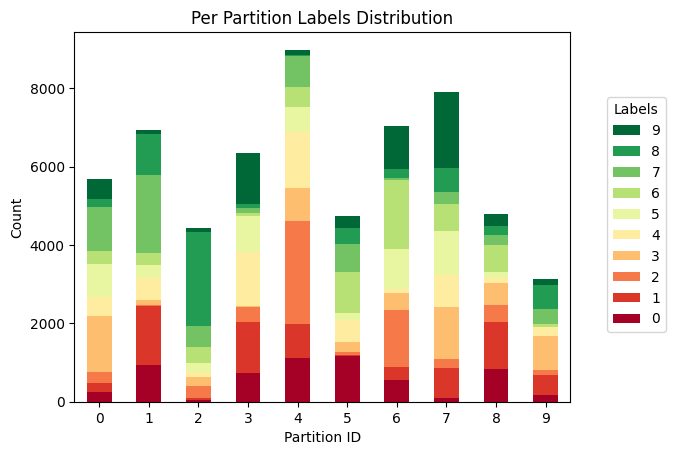

In [25]:
ALPHA = 1
# numero = 42
# numero = 88
numero = 90
# numero = 36
print(numero)
random.seed(numero)
torch.manual_seed(numero)
torch.cuda.manual_seed(numero)

# Criando o modelo global
modelo_global = MLP(DEVICE)
criterio = nn.CrossEntropyLoss(label_smoothing=0.1)
# criterio = nn.CrossEntropyLoss()

class Particula:
    def __init__(self, particle_id, modelo_cliente, teste):
        self.particle_id = particle_id
        # self.pesos = copy.deepcopy(modelo_cliente.state_dict())
        self.pesos = {f"_module.{key}": value.clone() for key, value in modelo_cliente.state_dict().items()}
        self.device = modelo_cliente.device
        self.teste = teste

        # Adiciona ruído leve nos pesos para quebrar simetria inicial
        for name in self.pesos:
            self.pesos[name] += 0.01 * torch.randn_like(self.pesos[name])

        self.melhor_pesos = copy.deepcopy(self.pesos)
        self.melhor_erro = float('inf')
        self.velocidade = {name: torch.zeros_like(param) for name, param in self.pesos.items()}


    def atualizar_pso(self, global_best_pesos, INERCIA, C1, C2):
        MAX_VELOCITY = 0.1  # Limite para evitar oscilações grandes
        if(round == 0):
          global_best_weights_adjusteds = {f"_module.{key}": value for key, value in global_best_pesos.items()}
        for name in self.pesos:
            local_rand = random.random()
            global_rand = random.random()
            self.velocidade[name] = (
                INERCIA * self.velocidade[name]
                + C1 * local_rand * (self.melhor_pesos[name] - self.pesos[name])
                + C2 * global_rand * (global_best_pesos[name] - self.pesos[name])
            )

            # Clipping da velocidade
            self.velocidade[name] = torch.clamp(self.velocidade[name], -MAX_VELOCITY, MAX_VELOCITY)

            # Atualiza os pesos com a nova velocidade
            self.pesos[name] += self.velocidade[name]

    def avaliar_perda(self, modelo_cliente, criterio):
        modelo_cliente.load_state_dict(self.pesos)
        modelo_cliente.eval()
        total_loss = 0
        device = next(modelo_cliente.parameters()).device

        with torch.no_grad():
            for inputs, labels in self.teste:
                inputs, labels =  inputs.to(DEVICE), labels.to(DEVICE)
                outputs = modelo_cliente(inputs)
                loss = criterio(outputs, labels)
                total_loss += loss.item()


        return total_loss / len(self.teste)

class Cliente:
    def __init__(self, cliente_id, modelo_global, dados, test, num_particulas):
        self.cliente_id = cliente_id
        self.modelo = copy.deepcopy(modelo_global)  # Cada cliente tem seu próprio modelo
        self.dados = dados
        self.test = test
        self.num_particulas = num_particulas
        self.particulas = []
        self.melhor_particula = None
        self.inicializar_particulas(num_particulas, test)
        self.optimizer = optim.Adam(self.modelo.parameters(), lr=0.0055)

    def inicializar_particulas(self, num_particulas, test):
        """Cria um conjunto de partículas associadas ao cliente."""
        self.particulas = [Particula(i, self.modelo, test) for i in range(num_particulas)]

    def treinar_com_pso(self, INERCIA, C1, C2, global_best_pesos, criterio):
        """Treina as partículas usando PSO e atualiza a melhor partícula local."""

        for particula in self.particulas:
            particula.atualizar_pso(global_best_pesos, INERCIA, C1, C2)
            erro = particula.avaliar_perda(self.modelo, criterio)
            if erro < particula.melhor_erro:
                particula.melhor_erro = erro
                particula.melhor_pesos = copy.deepcopy(particula.pesos)

        self.selecionar_melhor_particula()
        # modelo_global.load_state_dict(self.melhor_particula.pesos)

    def refinar_com_adam(self, criterio):
        """Refina os pesos da melhor partícula usando Adam."""
        self.modelo.load_state_dict(self.melhor_particula.melhor_pesos)
        # self.modelo.load_state_dict(modelo_global.state_dict())
        device = next(self.modelo.parameters()).device

        self.modelo.train()
        for i in range(1):
          with BatchMemoryManager(data_loader=self.dados, max_physical_batch_size=BATCH_SIZE, optimizer=self.optimizer) as new_data_loader:
            for batch in self.dados:
                inputs, labels = batch["image"].to(device), batch["label"].to(device)
                self.optimizer.zero_grad()
                outputs = self.modelo(inputs)
                loss = criterio(outputs, labels)
                loss.backward()
                self.optimizer.step()
        self.melhor_particula.melhor_pesos = copy.deepcopy(self.modelo.state_dict())
        self.melhor_particula.melhor_erro = self.calcular_loss(self.modelo, criterio, self.test)

    def calcular_loss(self, modelo, criterio, dados):
        self.modelo.eval()
        total_loss = 0

        with torch.no_grad():
            for inputs, labels in dados:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = modelo(inputs)
                loss = criterio(outputs, labels)
                total_loss += loss.item()

        return total_loss / len(dados)

    def selecionar_melhor_particula(self):
        """Seleciona a melhor partícula do cliente."""
        self.melhor_particula = min(self.particulas, key=lambda p: p.melhor_erro)


def treinar_federado(modelo_global, clientes, criterio, num_rodadas, INERCIA, C1, C2, testloader, validationloader):
    """Treina os clientes localmente e sincroniza com o servidor central, validando a acurácia."""

    melhor_peso_global = {f"_module.{key}": value.clone() for key, value in modelo_global.state_dict().items()}
    # melhor_peso_global =  copy.deepcopy(modelo_global.state_dict())
    melhor_erro_global = float('inf')
    soma = 0.0;
    for rodada in range(num_rodadas):
        resultados_rodada = []

        for cliente in clientes:
          cliente.modelo._module.load_state_dict(modelo_global.state_dict())
          cliente.treinar_com_pso(INERCIA, C1, C2, melhor_peso_global, criterio)  # Treino com PSO
          cliente.refinar_com_adam(criterio)  # Refinamento com Adam
          erro_cliente = cliente.melhor_particula.melhor_erro  # Obtém o melhor erro do cliente
          pesos_cliente = cliente.melhor_particula.melhor_erro  # Obtém os pesos do modelo do cliente
          resultados_rodada.append((cliente.cliente_id, erro_cliente))

        resultados_sorted = sorted(resultados_rodada, key=lambda x: x[1])

        top_3_results = resultados_sorted[:1]


        for i in range(len(resultados_sorted)):
          print(resultados_sorted[i])

        melhor_cliente = random.choice(top_3_results)
        melhor_cliente_id = melhor_cliente[0]
        melhor_erro_cliente = melhor_cliente[1]

        melhor_peso_global = copy.deepcopy(clientes[melhor_cliente_id].melhor_particula.melhor_pesos)
        melhor_peso_global_adjusted =  {key.replace("_module.", ""): value for key, value in melhor_peso_global.items()}
        melhor_erro_global = melhor_erro_cliente

        modelo_global.load_state_dict(melhor_peso_global_adjusted)
        # modelo_global.load_state_dict(melhor_peso_global)

        test_loss, test_accuracy = avaliar_modelo(modelo_global, criterio, validationloader)
        soma += test_accuracy
        test_accuracy= test_accuracy*100
        print(f"epsilon: {privacy_engines[0].get_epsilon(delta=1e-5)}")
        print(f"Rodada {rodada+1}/{num_rodadas}: Cliente {melhor_cliente_id} enviou os pesos!")
        print(f"Erro Global Atualizado: {melhor_erro_global:.4f}")
        print("Epsilon 10 desbalanceado extremo ")
        print(f"Teste -> Perda: {test_loss: .4f}, Acurácia: {test_accuracy: .4f}%\n")

    print(f"Acurácia média: {soma/num_rodadas: .2f}")
    print("Treinamento Federado Finalizado!")

def avaliar_modelo(modelo, criterio, testloader):
    """Avalia o modelo global no conjunto de teste."""
    modelo.eval()  # Modo de avaliação
    total_loss = 0
    correct = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = modelo(inputs)
            loss = criterio(outputs, labels)

            total_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
            total_samples += labels.size(0)

    test_loss = total_loss / len(testloader)
    test_accuracy = (correct / total_samples)

    return test_loss, test_accuracy
#criando dataloader de teste
from torchvision.datasets import MNIST
mnist_test = MNIST(root="./data", train=False, download=True)

#normalizacao
X_test = mnist_test.data.numpy().astype("float32") / 255.0
y_test = mnist_test.targets.numpy()

X_test = torch.tensor(X_test).unsqueeze(1)
X_test = (X_test - 0.1307) / 0.3081
y_test = torch.tensor(y_test, dtype=torch.long)

from torch.utils.data import TensorDataset
test_dataset_full = TensorDataset(X_test, y_test)

num_total = len(test_dataset_full)
num_val   = int(0.4 * num_total)
num_test  = num_total - num_val

val_dataset, test_dataset = random_split(test_dataset_full, [num_val, num_test], generator=torch.Generator().manual_seed(numero))

# Loaders separados
validationloader = DataLoader(val_dataset, batch_size=240, shuffle=False, num_workers=2, pin_memory=True)
testloader = DataLoader(test_dataset, batch_size=240, shuffle=False, num_workers=2, pin_memory=True)

#criando dataloaders de treino
from datasets import Dataset as HFDataset
from flwr_datasets.partitioner import DirichletPartitioner
from flwr_datasets.visualization import plot_label_distributions

mnist_raw = MNIST(root="./data", train=True, download=True)

imgs, labels = [], []
for img, lbl in mnist_raw:
    t = transforms.functional.to_tensor(img)          # (1,28,28) float32 em [0,1]
    t = (t - 0.1307) / 0.3081                         # normalização MNIST
    imgs.append(t.view(-1))                           # opcional: achata p/ 784
    labels.append(lbl)

# 3) Cria HuggingFace-Dataset já em formato Torch (evita .with_transform depois)
hf_dataset = HFDataset.from_dict(
    {"image": imgs, "label": labels}
).with_format("torch")


#Para testa balanceado comenta esse
partitioner = DirichletPartitioner( num_partitions=NUM_CLIENTES, partition_by="label", alpha=ALPHA, seed=numero
)
#e descomenta esse
# partitioner = IidPartitioner(
#     num_partitions=NUM_CLIENTES
# )

partitioner.dataset = hf_dataset

def get_trainloader(client_id: int):
    ds = partitioner.load_partition(client_id)        # já em torch.Tensor
    return DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True)



# (Opcional) Visualização da distribuição
fig, ax, df = plot_label_distributions(
    partitioner,
    label_name="label",
    plot_type="bar",
    size_unit="absolute",
    partition_id_axis="x",
    legend=True,
    verbose_labels=True,
    max_num_partitions=30,
    title="Per Partition Labels Distribution",
)

clientes = [Cliente(i, modelo_global, get_trainloader(i), validationloader, NUM_PARTICULAS) for i in range(NUM_CLIENTES)]
privacy_engines = [PrivacyEngine() for _ in range(NUM_CLIENTES)]
for i in range(NUM_CLIENTES):
    clientes[i].modelo.train()
    clientes[i].modelo, clientes[i].optimizer, clientes[i].dados = privacy_engines[i].make_private_with_epsilon(
        module=clientes[i].modelo,
        optimizer=clientes[i].optimizer,
        data_loader=clientes[i].dados,
        epochs=NUM_RODADAS ,
        target_epsilon=5,
        target_delta=1e-5,
        max_grad_norm=1.0
    )


print(modelo_global.state_dict()['fc1.weight'][0,0])
treinar_federado(modelo_global, clientes, criterio, NUM_RODADAS, INERCIA, C1, C2, testloader, validationloader)
print(modelo_global.state_dict()['fc1.weight'][0,0])

soma=0
test_loss, test_accuracy = avaliar_modelo(modelo_global, criterio, testloader)
soma += test_accuracy

# if (rodada+1) % 10 == 0:
test_accuracy= test_accuracy*100
print(f"Teste final -> Perda: {test_loss: .4f}, Acurácia: {test_accuracy: .4f}%\n")


for i in range(NUM_CLIENTES):
    print(privacy_engines[i].get_epsilon(delta=1e-5))